In [307]:
import numpy as np 
import pandas as pd 
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [292]:
# Entropy and Gini-index Functions. 
def H(p):
    """Calculates entropy from a probability distribution p. 

    Args:
        p ([1D Array]): [Probability Distribution]

    Returns:
        [Scalar]: [Entropy]
    """
    # Entropy Definition. 
    H = -np.sum(p*np.log2(p))
    return H 

def H_A(prob_low, dist_low, prob_high, dist_high):
    """Calculate Entropy change (E(T|A)) given False and Positive observations (A) from a two-
    possible outcome space. 

    Args:
        p_low ([1D Array]): [Probability distribution given false observation]
        p_high ([1D Array]): [Probability distribution given positive observation]

    Returns:
        [float]: [Weighted average Entropy E(T|A)]
    """
    # Calculate the Entropy change given observation/non observation. 
    return prob_low * H(dist_low) + prob_high*H(dist_high)


def giniValue(px):
    """Calculate gini-index for a probability distribution px

    Args:
        px ([1D-Array]): [Probability distribution.]

    Returns:
        [float]: [Gini-index for that probability distribution.]
    """
    return 1 - np.sum(px**2)

def G_A(prob_low, dist_low,prob_high,dist_high ):
    """Calculated the weighted average gini value between two vectors, where relative probabilities are known. 

    Args:
        prob_low ([float]): [Overall prob for lower vector]
        dist_low ([1D]-Array): [probability distribution for lower vector]
        prob_high ([float]): [Overall prob for lower upper vector]
        dist_high ([1D-Array]): [probability distribution for upper vector]

    Returns:
        [float]: [Weighted average gini-value between two vectors.]
    """
    return prob_low * giniValue(dist_low) + prob_high*giniValue(dist_high)

In [293]:


def probability_dist_label(y):
    """Calculate the probability distribution for a vector y (usually classification labels).

    Args:
        y ([1D Array]): [Vector ]

    Returns:
        [1D array]: [Probability for each value in the vector y]
    """
    from collections import Counter
    
    n_tot = len(y)
    
    # Dict, with unique values in y as keys, and the values being the number of observed outcomes. 
    count_labels = Counter(y)

    # Calculate probability by counting numbers of each class. 
    probs = []
    for val in count_labels.values():
        probs.append(val/n_tot)
    return np.array(probs)

def informationGain(X,y):
   """[Calculates the information gain IG for each feature in a feature matrix "X".]

   Args:
       X ([nD-array]): [Feature Matrix]

   Returns:
       [1D List]: [list of Information gain for each feature]
   """
   # Store IG for each of the features in list. 
   IG_list = []

   # Number of rows. 
   N_tot = len(X)

   # Original Distributions before observations. (used for E(T) and G(T))
   T = probability_dist_label(y)
   
   # Loop over each Feature-column. 
   n_col = len(X[0])
   for i in range(n_col):
      feature_i = X[:,i]
      # Split feature based on its mean value. 
      index_low =  feature_i <  np.mean(feature_i)
      index_high = feature_i >=  np.mean(feature_i)

      # Split Feature and Labels. 
      feature_low = feature_i[index_low]
      y_low = y[index_low]

      feature_high = feature_i[index_high]
      y_high = y[index_high]

      # Probability for being below or above mean. 
      prob_low = len(feature_low) / N_tot
      prob_high = len(feature_high) / N_tot

      # Calculate Proability distributions of Labels in new categories (below and above mean.)
      dist_low = probability_dist_label(y_low)
      dist_high = probability_dist_label(y_high)
      
      # Calculate the IG based on its definition and append to list. 
      HA = H_A(prob_low, dist_low, prob_high, dist_high)
      IG = H(T) - HA 
      IG_list.append(IG)
      continue
   return IG_list

    
def giniList(X,y):
    """Calculate the Gini-Index for every feature in X, by splitting the data on its mean value.

    (Almost Identical Implementation as for Informationgain(X) function.)

    Args:
        X ([nD-Array]): [Feature Matrix]
        y ([1D-Array]): [Labels/Classes - Target vector/True Cases]

    Returns:
        [type]: [description]
    """
    # Store gini values for every feature. 
    gini_values = []

    # total Gini value before splitting. 
    T = probability_dist_label(y)
    N_tot = len(y)
   
    # Loop over each Feature
    n_col = len(X[0])
    for i in range(n_col):
        feature_i = X[:,i]
    
        # Find index of feature based on its mean value. 
        index_low =  feature_i <  np.mean(feature_i)
        index_high = feature_i >=  np.mean(feature_i)
       
        # Split Feature and Labels on mean index. 
        feature_low = feature_i[index_low]
        y_low = y[index_low]
        
        feature_high = feature_i[index_high]
        y_high = y[index_high]

        # Calculate Probability for being below or above mean. 
        prob_low = len(feature_low) / N_tot
        prob_high = len(feature_high) / N_tot

        # Generate probability distributions for labels.
        dist_low = probability_dist_label(y_low)
        dist_high = probability_dist_label(y_high)

        # Calculate gini_gain before and after split. 
        gini_gain = giniValue(T) - G_A(prob_low, dist_low,prob_high,dist_high) 
        gini_values.append(gini_gain)
        continue

    return gini_values


In [294]:
class tree:
    """[A decision Tree Class used for Machine Learning classification.]

    Returns:
        [Object]: [An instance of this class, That can be trained to perform predicitons.]
    """
    # Store Right/LEft Branches (called nodes)
    nodes_left = None
    nodes_right = None

    # Store Feature Split Value. 
    root = None

    # Store Leaf Value (No branches if this is different from None).  
    leaf = None 

    def __init__(self, val = None, feat = None):
        """Nodes in the tree are defined by other tree instances. 

        Args:
            val ([float], optional): [Feature split value (usually mean)]. Defaults to None for root.
            feat ([int], optional): [column index for features]. Defaults to None - set during learning.
        """
        # Store Feature and Splitting Value in Tree-Node. 
        self.root = val
        self.feature = feat


    def copy(self):
        """Create a copy of the current Tree-Object.

        Returns:
            [Tree()]: [Copy of self]
        """
        copy_tree = tree()
        copy_tree.feature = self.feature
        copy_tree.leaf = self.leaf
        copy_tree.nodes_right = self.nodes_right
        copy_tree.nodes_left = self.nodes_left
        copy_tree.root = self.root
        return copy_tree

    def print_leaf(self):
        """Itterate over all leafs, and prints them (used during testing).
        """
        if self.leaf != None:
            print(self.leaf)
            
        if self.nodes_right:
            right_branch = self.nodes_right 
            right_branch.print_leaf()
        if self.nodes_left:
            left_branch = self.nodes_left 
            left_branch.print_leaf()
        return

    def get_leaf(self, leaf_dict):
        """Adds a leaf of current branch to input dictionary.

        Args:
            leaf_dict ([dict]): [dict of labels e.g {"g":102, "h": 123}]

        Returns:
            [dict]: [Returns dict with a leaf added the counted values.]
        """
        if self.leaf != None:
                if self.leaf not in leaf_dict:
                    leaf_dict[self.leaf] = 1
                    return leaf_dict
                else:
                    leaf_dict[self.leaf] += 1
                    return leaf_dict
        else:
            return leaf_dict

    def find_leaf(self, leaf_dict = {}):
        """Itterates over all leafs and return a dictionary with labels as keys and their count as values.

        Args:
            leaf_dict (dict, optional): [the dict to store values in, initilized as the empty dict.]. Defaults to {}.

        Returns:
            [dict]: [A dictionary where the type of leafs have been counted]
        """
        # Check if nodes are not None. 
        if self.nodes_left: 
            leaf_dict = self.nodes_left.get_leaf(leaf_dict)
            self.nodes_left.find_leaf(leaf_dict)
        if self.nodes_right:
            leaf_dict = self.nodes_right.get_leaf(leaf_dict)
            self.nodes_right.find_leaf(leaf_dict)
                
        return leaf_dict


    def count_correct_predictions(self, y_true,y_pred, print_results = True):
        """Count the number of correct and faulty predictions given a prediction-vector and true values. 

        Args:
            y_true ([1D array]): [True values (usually test set)]
            y_pred ([1D array]): [Predicted values]

        Returns:
            [type]: [Returns the number of correct predictions and prints out relevant prediction ratios.]
        """

        # Force numpy to convert Boolean data to binary. 
        binary_representation = np.array((y_pred == y_true), dtype = int)
    
        # Compute Correct, and False predictions. 
        N_samples = len(binary_representation)
        N_correct = np.sum(binary_representation)
        N_false = N_samples - N_correct

        # Print Ratio statements about accuracy.
        if print_results:
            print("Correct Predictions", N_correct, "/", N_samples )
            print("Missed Predictions", N_false, "/", N_samples )
        return np.sum(binary_representation)

    def r2_score(self, y_true, y_pred):
        """Compute R-Squared value given predicted and true values.

        Args:
            y_true ([1D array]): [True values]
            y_pred ([1D array]): [Predicted values]

        Returns:
            [type]: [R-Score, values close to 1 correspond to high accuracy.]
        """
        import pandas as pd 
        
        # Convert from catagorical predictions, to binary representation. 
        df = df = pd.DataFrame(data=({0:y_true, 1:y_pred}))
        df_binary = pd.get_dummies(df)

        y_pred_binary = df_binary.iloc[:,1]
        y_true_binary = df_binary.iloc[:,0]

        # Compute Definitions of R2.
        SSr = np.sum((y_pred_binary- y_true_binary)**2)
        SSt = np.sum((y_true_binary - np.mean(y_true_binary))**2)

        # R-Score. 
        return 1 - SSr/SSt

    def traverseTree(self,X):
        """Traverse down a "learned-Tree" based on values in X, and locate leafs for predictions.

        Args:
            X ([nD-Array]): [Feature Matrix to be predicted.]

        Returns:
            [Scalar']: [Predicted value for a given row in X]
        """
        # If there is a leaf, we have located an prediction. 
        if self.leaf != None:
                return self.leaf 
        # Otherwise Keeep traversing. 
        else:
            if X[self.feature] < self.root:
                node_low = self.nodes_left 
                return node_low.traverseTree(X)
            else:
                node_high = self.nodes_right 
                return node_high.traverseTree(X)

    def predict(self, X):
        """[Predict each row in feature matrix X, by using previously defined traverse function on each row. ]

        Args:
            X ([nD-Array]): [Feature Matrix - X_test]
            impurity_measure (str, optional): [Feature Selection Metric]. Defaults to 'entropy'.

        Returns:
            [1d Array]: [Predictions - Y_pred]
        """

        # Check if the learn-function has been called. (Must be stored right/left nodes in root.)
        if not self.nodes_right and not self.nodes_left:
            print("Can Predict With An Un-Fitted Tree")
            return 
            
        # Initilize Vector to store predictions in. 
        n_row = len(X)
        pred_y = list(range(n_row))

        # Traverse each row in feature matrix. 
        for i in range(n_row):
            pred_y[i] = self.traverseTree(X[i,:])
            
        return np.array(pred_y, dtype="object")


    def prune_self(self, X_prune, y_prune):
        """Reduce the number of leafs/branches by pruning a trained tree.

        Args:
            X_prune ([nd-Matrix]): [Feature Matrix]
            y_prune ([1d-vector]): [Target/label vector]
        """
        
        # Original Predictions before pruning. 
        original_pred = self.predict(X_prune)
        original_correct = self.count_correct_predictions(y_prune, original_pred, print_results=False)

        # Prune Right Branch. 
        if self.nodes_right and not self.nodes_right.leaf:
        
            #Get Label/Leaf that occurs most from sub-tree.
            sub_tree = self.copy().nodes_left
            leaf_dict = sub_tree.find_leaf()
            max_leaf = max(leaf_dict, key=leaf_dict.get)

            # Exchange sub-branch with leaf. 
            prune_tree = self.copy()
            prune_tree.nodes_left.leaf = max_leaf
            prune_pred = prune_tree.predict(X_prune)
            prune_correct = self.count_correct_predictions(y_prune, prune_pred ,print_results=False)

            # Swap out left branch with most occuring leaf. 
            if prune_correct >= original_correct:
                self.nodes_right.leaf = max_leaf
                self.nodes_right.nodes_right = None
                self.nodes_left.nodes_left  = None
            else:
                self.nodes_left.prune_self(X_prune,y_prune)

        # Prune Right Branch. 
        if self.nodes_left and not self.nodes_left.leaf:
            #Get Label/Leaf that occurs most from sub-tree. 
            sub_tree = self.copy().nodes_left
            leaf_dict = sub_tree.find_leaf()
            max_leaf = max(leaf_dict, key=leaf_dict.get)

            # Exchange branch with leaf. 
            prune_tree = self.copy() 
            prune_tree.nodes_left.leaf = max_leaf
            prune_pred = prune_tree.predict(X_prune)
            prune_correct = self.count_correct_predictions(y_prune, prune_pred, print_results=False)

            # Swap out left branch with most occuring leaf. 
            if prune_correct >= original_correct:
                self.nodes_left.leaf = max_leaf
                self.nodes_left.nodes_right = None
                self.nodes_left.nodes_left  = None
            else:
                self.nodes_left.prune_self(X_prune,y_prune)
        return

    def learn_fullTree(self,X,y,impurity_measure='entropy'):
        """Learn or train the given tree class on a feature matrix X, with corresponding label-vector y. 

        Args:
            X ([nD-Array]): [Feature Matrix - X_train]
            y ([1d-Array]): [Target Vector - Y_train]

        """
           
        # Convert y to numpy array if list - otherwise assume that it is. 
        if not isinstance(y, np.ndarray): 
            y = np.array(y)
        
        # Convert X to numpy array. 
        if isinstance(X, list):
            X = np.array(X)

        # Y is the single scalar value.
        if y.size == 0:
            print("EMPTY!")
            
        # All Labels Equal (Base Case). 
        if np.all(y == y[0]):
            self.leaf = y[0]
            return

        # All rows are equal (--> Identical Features. )
        # Return a leaf with the most common label (Base Case)
        elif (X == X[0]).all():
            countValues = Counter(y)
            self.leaf = max(countValues, key=countValues.get)
            return
        else:
            # Select next feature based MAX IG.  
            if impurity_measure == 'entropy': 
                IG_list = informationGain(X,y)
                max_feature_index = IG_list.index(max(IG_list))
                feature = X[:,max_feature_index]
            
            # Select next feature based on MIN Gini. 
            elif impurity_measure == 'gini':
                 gini_list = giniList(X,y)
                 max_feature_index = gini_list.index(max(gini_list))
                 feature = X[:,max_feature_index]
                
            # Split based on mean. 
            index_low = feature <  np.mean(feature)
            index_high = feature >= np.mean(feature)

            # Split X and Y vectors in Left/Right Branch. 
            X_low = X[index_low,:]
            y_low= y[index_low]
            
            X_high = X[index_high,:]
            y_high = y[index_high]
            
            # Set Splitting value to root of this branch-node for later traversal. 
            self.root = np.mean(feature)
            self.feature = max_feature_index
    
            # Create new branches if there are data points for these vectors.
            if y_low.size != 0:
                left_branch = tree()
                left_branch.learn_fullTree(X_low,y_low, impurity_measure = impurity_measure)
                self.nodes_left = (left_branch)

            # Learn and store right branch. 
            if y_high.size != 0:
                right_branch = tree()
                right_branch.learn_fullTree(X_high, y_high, impurity_measure = impurity_measure)
                self.nodes_right = (right_branch)
        return

    def learn(self,X,y,impurity_measure='entropy', prune = False, prune_size = 0.15):
        """Main Learning function used in root-instance of this tree class when fitting training data. 

        Args:
            X ([nd-Array (dtype = floats)]): [Feature Matrix]
            y ([1d-Array (dtype = objects)]): [Labels / Classes]
            impurity_measure (str, optional): [Information selection metric]. Defaults to 'entropy', "gini" is second option.
            prune (bool, optional): [Prunes tree and reduces number of branches / leafs]. Defaults to False.
            prune_size (float, optional): [test_size to split the trainin data in, if prune.]. Defaults to 0.15.
        """
        # Perform Normal Learning Then Prune the tree. 
        if prune:
            X2, X_prune, y2, y_prune = train_test_split(X,y, test_size = prune_size)
            # First Build Initial Tree, Then Prune it. 
            self.learn_fullTree(X2,y2, impurity_measure)
            self.prune_self(X_prune, y_prune)
        else:
             self.learn_fullTree(X,y, impurity_measure)



In [295]:
# IMPORT DATA FOR TESTING. 
magic_data  = pd.read_csv("magic04.data", header = None)

# NOTE- This was mainly used during test-phase. And in the pdf report N_samples = 15000 were used when documenting some results.  
N_samples = len(magic_data)

# Sample data for quicker learning and predictions 
magic_sample = magic_data.sample(n = N_samples)

# Convert data to numpy arrays. 
X = magic_sample.iloc[:,0:9].to_numpy()
y = magic_sample[10].to_numpy()

# Test and Training Sets (For when building the algorithm). 
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size =0.3)

In [296]:
# Compare the number of leafs before and after pruning, using the self.find_leaf() function. 
# Not Pruned. 
print("\n BEFORE PRUNING: Prediction and Leafs.")
my_tree = tree()
impurity_measure = "entropy"
my_tree.learn(X_train,Y_train, impurity_measure = impurity_measure, prune = False)
print("leafs", my_tree.find_leaf(leaf_dict={}))
y_pred = my_tree.predict(X_test)
my_tree.count_correct_predictions(Y_test, y_pred)

# Pruned 
print("\n AFTER PRUNING: Prediction and Leafs.")
my_tree = tree()
impurity_measure = "entropy"
my_tree.learn(X_train,Y_train, impurity_measure = impurity_measure, prune = True, prune_size = 0.15)
print("Leafs", my_tree.find_leaf(leaf_dict={}))
y_pred = my_tree.predict(X_test)
my_tree.count_correct_predictions(Y_test, y_pred)


 BEFORE PRUNING: Prediction and Leafs.
leafs {'g': 1532, 'h': 1195}
Correct Predictions 4502 / 5706
Missed Predictions 1204 / 5706

 AFTER PRUNING: Prediction and Leafs.
Leafs {'g': 964, 'h': 790}
Correct Predictions 4460 / 5706
Missed Predictions 1246 / 5706


4460

In [297]:
# Just to show the accuracy of the pruned tree.  
from sklearn.metrics import accuracy_score
y_pred = my_tree.predict(X_test)
print("Pruned Tree Accuracy.")
accuracy_score(Y_test, y_pred)

Pruned Tree Accuracy.


0.781633368384157

## Task 1.4) Evaluate your algorithm 

In [298]:
# Split into 70/30 Traning/Testing. 
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X,y, test_size =0.3)

# Split into 50/50 Validation/Testing data. 
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test,Y_val_test, test_size =0.5)

In [299]:
from sklearn.metrics import accuracy_score

# Parameter Space. (9 Models in total.)
impurity_metric = ["entropy", "gini"]
prune_metric = [False, True]
prune_sizes = [0.05,0.15,0.75]

# Store Parameter specifc names and corresponding accuracy scores. 
model_name = []
model_accuracy = []
model_list = []


# Loop over models, Train and evaluate accuracy. 
for infoormation_metric in impurity_metric:
    for prune_val in prune_metric:
        for prune_size in prune_sizes:
            
            if prune_val:
                model = tree()
                model.learn(X_train, Y_train, impurity_measure=infoormation_metric, prune=prune_val, prune_size=prune_size)
                name = infoormation_metric + "| prune-size =" + str(prune_size)
                model_name.append(name)
            else:
                model = tree()
                model.learn(X_train, Y_train, impurity_measure=infoormation_metric)
                name = infoormation_metric + "| No Prune"
                model_name.append(name)

            Y_val_predicted = model.predict(X_val)
            accuracy = accuracy_score(Y_val, Y_val_predicted)
            model_accuracy.append(accuracy)
            model_list.append(model)


print("Model Validation Scores \n")
for i, name in enumerate(model_name):
    print("Model: ",name, "-Score = ", model_accuracy[i])


Model Validation Scores 

Model:  entropy| No Prune -Score =  0.7960042060988434
Model:  entropy| No Prune -Score =  0.7960042060988434
Model:  entropy| No Prune -Score =  0.7960042060988434
Model:  entropy| prune-size =0.05 -Score =  0.7921486154924641
Model:  entropy| prune-size =0.15 -Score =  0.7872415001752541
Model:  entropy| prune-size =0.75 -Score =  0.650192779530319
Model:  gini| No Prune -Score =  0.7956536978618998
Model:  gini| No Prune -Score =  0.7956536978618998
Model:  gini| No Prune -Score =  0.7956536978618998
Model:  gini| prune-size =0.05 -Score =  0.7942516649141255
Model:  gini| prune-size =0.15 -Score =  0.7907465825446898
Model:  gini| prune-size =0.75 -Score =  0.650192779530319


C:\Users\erikf\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


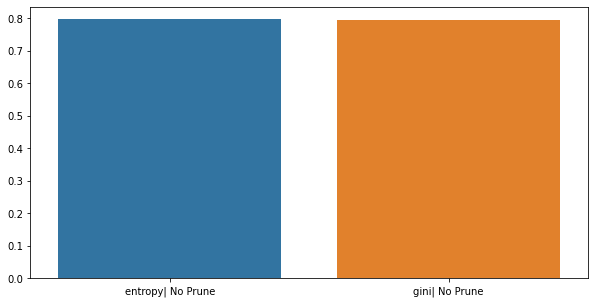

In [300]:
# Generate Bar-Chart ()
import seaborn as sns
fig,ax  = plt.subplots(figsize=(10,5))

# For returning the 4 best models in the score-list.  
import heapq
best_4_vals = heapq.nlargest(4, model_accuracy)

# Get the Best 4 Models. 
best_4_index = []
for val in best_4_vals:
    val_index =  model_accuracy.index(val)
    best_4_index.append(val_index)
    
best_4_names = [model_name[i] for i in best_4_index]

# If the numbers are close to identical, there might be plotted less than 4 bars. 
ax_bar = sns.barplot(best_4_names, best_4_vals)

In [301]:
# Find the best model from accuracy scores. 
best_model_index = model_accuracy.index(max(model_accuracy))
best_model = model_list[best_model_index]
best_model_name = model_name[best_model_index]

print("Best Model:  = " + best_model_name)

# Perform predictions on test-set. 
y_pred_best = best_model.predict(X_test)

best_model_score = accuracy_score(Y_test, y_pred_best)

print("Best Model TestSet-Score = ", best_model_score)
print("Best Model Validation-Score = ", max(model_accuracy))


Best Model:  = entropy| No Prune
Best Model TestSet-Score =  0.8047669120224326
Best Model Validation-Score =  0.7960042060988434


Confusion Matrix, Model =  entropy| No Prune


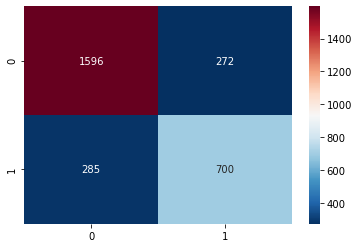

In [302]:
# Evaluate best results in Confusion Matrix. 
from sklearn.metrics import confusion_matrix
confusionMatrix = confusion_matrix(Y_test,y_pred_best)

# Generate a Heat-Map Display of the confusion matrix. (From Class-Template Notebook.) 
sns.heatmap(data=confusionMatrix.round(2), annot=True, fmt='d', cmap=sns.color_palette("RdBu_r", 1000))
print("Confusion Matrix, Model = ", best_model_name)

|GINI|
SciKit-Learn-Gini Validation Score =  0.8250963897651595
SciKit-Learn-Gini Test Score =  0.830354013319313

|ENTROPY|
SciKit-Learn-Entropy Validation Score =  0.8212407991587802
SciKit-Learn-Entropy Test Score =  0.8131791097090781

|COMMENT|
Test score for Sklearn was found to be  0.830354013319313 VS my algorithm, with a test score of  0.8047669120224326


Text(0.5, 1.0, 'Test-Set Score Comparison With Sk-Learn Algorithms.')

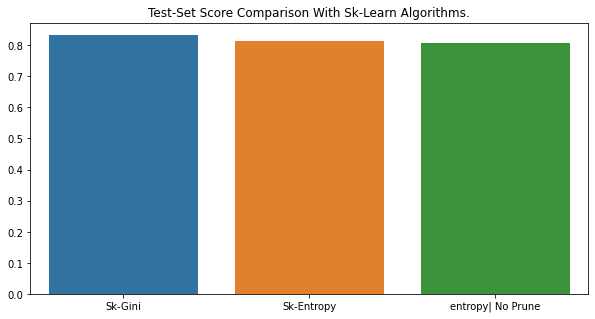

In [306]:
from sklearn import tree

# Comparing with sklearn-default-Gini. 
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
sk_tree_pred_val = clf.predict(X_val)

sk_tree_score = accuracy_score(Y_val,sk_tree_pred_val )
sk_tree_pred_test = clf.predict(X_test)
sk_tree_gini_test=accuracy_score(Y_test, sk_tree_pred_test)

# Print validation and test-results. 
print("|GINI|")
print("SciKit-Learn-Gini Validation Score = ",sk_tree_score)
print("SciKit-Learn-Gini Test Score = ",sk_tree_gini_test)

# Comparing with sklearn entropy. 
clf = tree.DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X_train, Y_train)
sk_tree_pred_val = clf.predict(X_val)
sk_tree_score = accuracy_score(Y_val,sk_tree_pred_val )
sk_tree_pred_test = clf.predict(X_test)
sk_tree_score_entropy_test=accuracy_score(Y_test,sk_tree_pred_test)

# Print validation and test-results. 
print("\n|ENTROPY|")
print("SciKit-Learn-Entropy Validation Score = ",sk_tree_score)
print("SciKit-Learn-Entropy Test Score = ",sk_tree_score_entropy_test)

print("\n|COMMENT|")
print("Test score for Sklearn was found to be ",max(sk_tree_score_entropy_test,sk_tree_gini_test) , "VS my algorithm, with a test score of ", best_model_score)

sk_names =["Sk-Gini", "Sk-Entropy", best_model_name]

# Create a barplot. 
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x = sk_names, y = [sk_tree_gini_test,sk_tree_score_entropy_test, best_model_score])
ax.set_title("Test-Set Score Comparison With Sk-Learn Algorithms.")